In [1]:
from itertools import zip_longest
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse import find
from pickleshare import *

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#tokenize and sanitize

#tokenize documents into individual words
df['tokenized'] = df.headline_text.str.split(' ')

#remove short documents from corpus
df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]

#use random subset of corpus
df=df.sample(frac=0.0001)

#flatten all words into single series
ex = df.explode('tokenized')

#remove shorter words
ex = ex.loc[ex.tokenized.str.len() > 2]

#remove stopwords
ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [3]:
#ceate dictionary of words

#shuffle for sparse matrix visual
dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

#dataframe with (index/code):word
dictionary = pd.Series(dictionary.tolist(), name='words').to_frame()

#store code:word dictionary for reverse encoding
dictionary_lookup = dictionary.to_dict()['words']

#offset index to prevent clash with zero fill
dictionary['encode'] = dictionary.index + 1

#store word:code dictionary for encoding
dictionary = dictionary.set_index('words').to_dict()['encode']


In [4]:
#reduced grouping from group by dataframeto to group by series and aggregated to tuple
#improved from 30s to 20s with whole dataset

#use dictionary to encode each word to integer representation
encode = ex.tokenized.map(dictionary.get).to_frame()
encode.index.astype('int')
encode.tokenized.astype('int')
#un-flatten encoded words back into original documents
docs = encode.tokenized.groupby(level=0).agg(tuple)


/home/codespace/.local/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: using autorestore/sparse_word_doc_matrix requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


Stored 'sparse_word_doc_matrix' (csc_array)


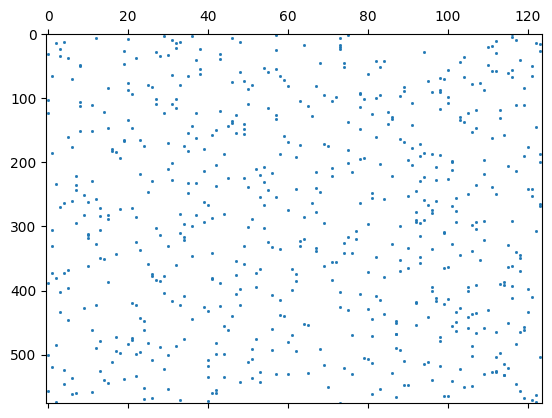

In [5]:

#zero pad x dimention by longest sentence
encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

#convert to sparse matrix
encoded_docs = csr_array(encoded_docs, dtype=int)

#convert to index for each word
row_column_code = find(encoded_docs)

#presort by words
word_sorted_index = row_column_code[2].argsort()
doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

#presort by docs and words
doc_word_sorted_index = doc_word[0].argsort()
doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

#offset code no longer needed after zerofill
doc_word.word = doc_word.word - 1

#convert to index of word counts per document
doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

#convert to sparse matrix
sparse_word_doc_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float).T

#visualize sparse matrix
fig = figure()
sparse_word_doc_matrix_visualization = fig.add_subplot(1,1,1)
sparse_word_doc_matrix_visualization.spy(sparse_word_doc_matrix, markersize=1, aspect = 'auto')

%store sparse_doc_word_matrix
%store dictionary
%store dictionary_lookup
